# Exponential Smoothing and Simple Linear Regression Exercise


In [131]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.patches as mpatches
import seaborn as sns
import statsmodels.api as sm
import math
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import os 

## Background: In this notebook, I wanted to explore exponential smoothing on time series data, and I wanted to utilize simple linear regression to predict the future

For my analysis, I chose a data source detailing tuition rates from Harvard Law School.

In [79]:
#importing the data from a downloaded csv
Harvard = pd.read_csv('tuition_graduate.csv')

In [80]:
Harvard

,academic.year,school,cost
0,1985,Business (MBA),10000
1,1986,Business (MBA),10750
2,1987,Business (MBA),11900
3,1988,Business (MBA),13300
4,1989,Business (MBA),14250
...,...,...,...
292,2013,Public Health (1-Year MPH),42160
293,2014,Public Health (1-Year MPH),45900
294,2015,Public Health (1-Year MPH),50320
295,2016,Public Health (1-Year MPH),55125


In [81]:
#Isolating records from Harvard Law
Law = Harvard.loc[Harvard['school']=='Law']

In [82]:
Law.head()

,academic.year,school,cost
198,1985,Law,8800
199,1986,Law,9650
200,1987,Law,10700
201,1988,Law,11400
202,1989,Law,12307


In [83]:
Law.tail()

,academic.year,school,cost
226,2013,Law,49950
227,2014,Law,52350
228,2015,Law,54850
229,2016,Law,57200
230,2017,Law,59550


In [84]:
#Wow! Tuition rates have increased by nearly seven times in a 32 year period
59550/8800

6.767045454545454

In [85]:
2017-1985

32

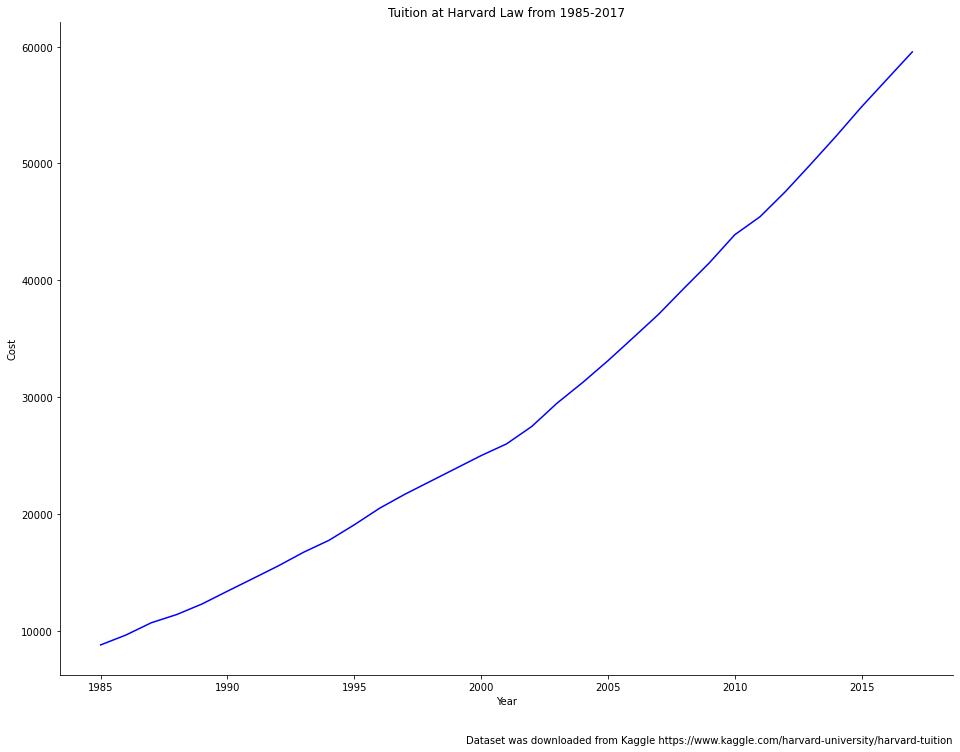

In [86]:
#Visualize the change of tuition rates between 1985 and 2017
fig, ax = plt.subplots(1,1, figsize=(16,12)) 
ax.plot(Law['academic.year'], Law['cost'],
       color='blue', label="Law")

ax.set_ylabel('Cost')  
ax.set_xlabel('Year')                 
ax.set_title('Tuition at Harvard Law from 1985-2017')

ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False) 

#ax.legend(frameon=False,loc='upper left',fontsize=16)

ax.annotate('Dataset was downloaded from Kaggle https://www.kaggle.com/harvard-university/harvard-tuition',
            xy = (1.0, -0.1),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)


plt.show()  

Tuition at Harvard Law is growing at a linear rate.

# After getting a feel for the basics of data importing and visualization, I wanted to shift my focus to a non-linear dataset 
I downloaded the monthly data series CPIAUCSL, which is the seasonally adjusted consumer price index
for all urban consumers in the US, from the St. Louis Fed Data Base (FRED).

First, I convert the time series into natural logs and take the first difference of the transformed
data; this is the monthly inflation rate (with continuous compounding). Then, I multiply the
monthly inflation rate by 12 to annualize, then multiply by 100 to put it into percentage
terms. My goal is to find the average annual inflation rate from January 1950 to December 2021.

In [87]:
#For this exercise, I limited my data to only include information after 1950.
start = datetime.datetime(1950, 1, 1)
#end = datetime.datetime(2021, 12, 31)

In [88]:
#Import the data from fred
df = web.DataReader(['CPIAUCSL'],'fred',start)
df.index.names = ['Date']
df.rename(columns={'CPIAUCSL': 'CPI'}, inplace=True)

In [89]:
df

,CPI
Date,
1950-01-01,23.510
1950-02-01,23.610
1950-03-01,23.640
1950-04-01,23.650
1950-05-01,23.770
...,...
2022-12-01,298.990
2023-01-01,300.536
2023-02-01,301.648


In [90]:
#Create a column to contain the natural log of the CPI in order to curb exponential effect
df["lnCPI"]=np.log(df['CPI'])

In [91]:
#Create a first difference column to prepare the dataframe to show annual growth
df["First_difference"]=df['lnCPI']-df['lnCPI'].shift(1)

In [92]:
#Annualize the first difference by multiplying by 12, this prepares us to shift the dataset to an annual view
df['Annualize']=df["First_difference"]*12

In [93]:
#Put into Percent terms by multiplying by 100
df['Percentage']=df["Annualize"]*100

In [94]:
df

,CPI,lnCPI,First_difference,Annualize,Percentage
Date,,,,,
1950-01-01,23.510,3.157426,NaN,NaN,NaN
1950-02-01,23.610,3.161670,0.004244,0.050934,5.093386
1950-03-01,23.640,3.162940,0.001270,0.015238,1.523810
1950-04-01,23.650,3.163363,0.000423,0.005075,0.507507
1950-05-01,23.770,3.168424,0.005061,0.060734,6.073400
...,...,...,...,...,...
2022-12-01,298.990,5.700410,0.001312,0.015743,1.574329
2023-01-01,300.536,5.705568,0.005157,0.061889,6.188903
2023-02-01,301.648,5.709261,0.003693,0.044319,4.431873


In [95]:
#Resample dataset to give data points on a yearly basis, and summarize the values with their average within the year
dfy = df.resample('A').mean()
dfy

,CPI,lnCPI,First_difference,Annualize,Percentage
Date,,,,,
1950-12-31,24.062500,3.180483,0.005514,0.066163,6.616325
1951-12-31,25.973333,3.257020,0.004828,0.057937,5.793651
1952-12-31,26.566667,3.279647,0.000752,0.009026,0.902601
1953-12-31,26.768333,3.287211,0.000498,0.005972,0.597240
1954-12-31,26.865000,3.290820,-0.000311,-0.003729,-0.372857
...,...,...,...,...,...
2019-12-31,255.651667,5.543794,0.001906,0.022876,2.287622
2020-12-31,258.850583,5.556227,0.001094,0.013134,1.313375
2021-12-31,270.971417,5.601794,0.005790,0.069474,6.947437


No handles with labels found to put in legend.


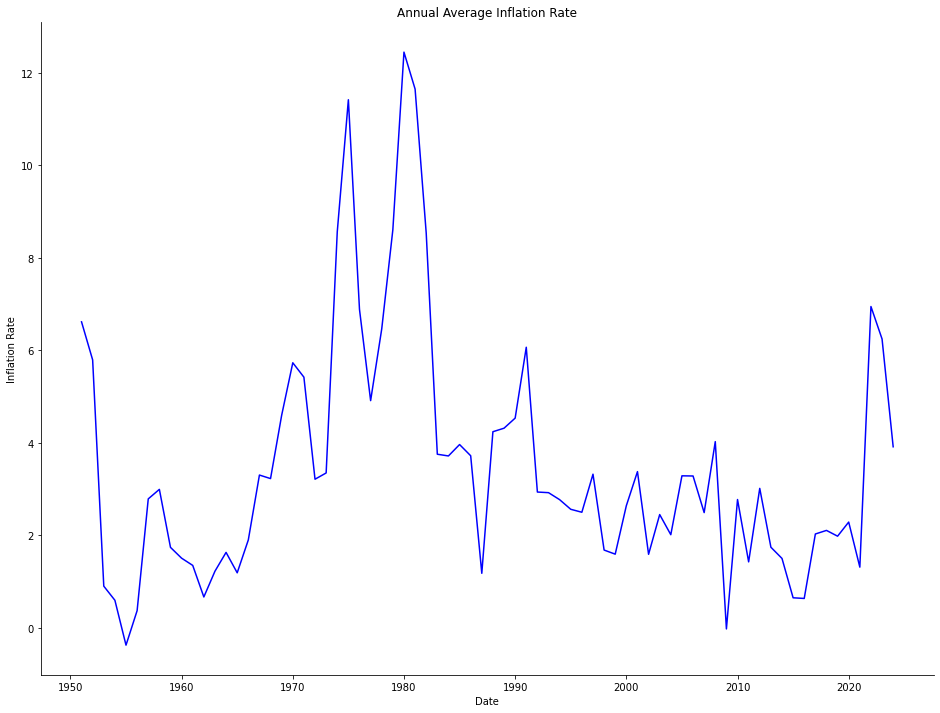

In [96]:
#Visualize the annual average inflation rate
fig, ax = plt.subplots(1,1, figsize=(16,12)) 
ax.plot(dfy.index, dfy['Percentage'],
       color='blue',
       linestyle='-')

ax.set_ylabel('Inflation Rate')  
ax.set_xlabel('Date')                 
ax.set_title('Annual Average Inflation Rate')


ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False) 

ax.legend(frameon=False,loc='upper left',fontsize=16)

plt.show()  

Now that I have the inflation rate visualized, I first want to use an unweighted moving average to help with visualization and prediction of future values. I plan on narrowing the time period to January 2000 to December 2021 to narrow down the dataset, and I will use a lagged 11-month unweighted moving average (n = 11 and m = 0).

In [97]:
y = df['Percentage']
y

Date
1950-01-01         NaN
1950-02-01    5.093386
1950-03-01    1.523810
1950-04-01    0.507507
1950-05-01    6.073400
                ...   
2022-12-01    1.574329
2023-01-01    6.188903
2023-02-01    4.431873
2023-03-01    0.636335
2023-04-01    4.405306
Name: Percentage, Length: 880, dtype: float64

In [98]:
#Narrow down the timeframe
y = y.iloc[600:]

In [99]:
#https://towardsdatascience.com/moving-averages-in-python-16170e20f6c

In [100]:
#Create 11 month rolling average
z = y.rolling(11).mean()
z

Date
2000-01-01         NaN
2000-02-01         NaN
2000-03-01         NaN
2000-04-01         NaN
2000-05-01         NaN
                ...   
2022-12-01    6.150676
2023-01-01    5.939752
2023-02-01    5.251125
2023-03-01    4.877596
2023-04-01    4.278364
Name: Percentage, Length: 280, dtype: float64

In [101]:
#Combine the dataframes
data=pd.concat({'Actual':y, 'Smoothed':z}, axis=1)
data

,Actual,Smoothed
Date,,
2000-01-01,3.549248,NaN
2000-02-01,4.951377,NaN
2000-03-01,7.038143,NaN
2000-04-01,-0.701960,NaN
2000-05-01,2.104648,NaN
...,...,...
2022-12-01,1.574329,6.150676
2023-01-01,6.188903,5.939752
2023-02-01,4.431873,5.251125


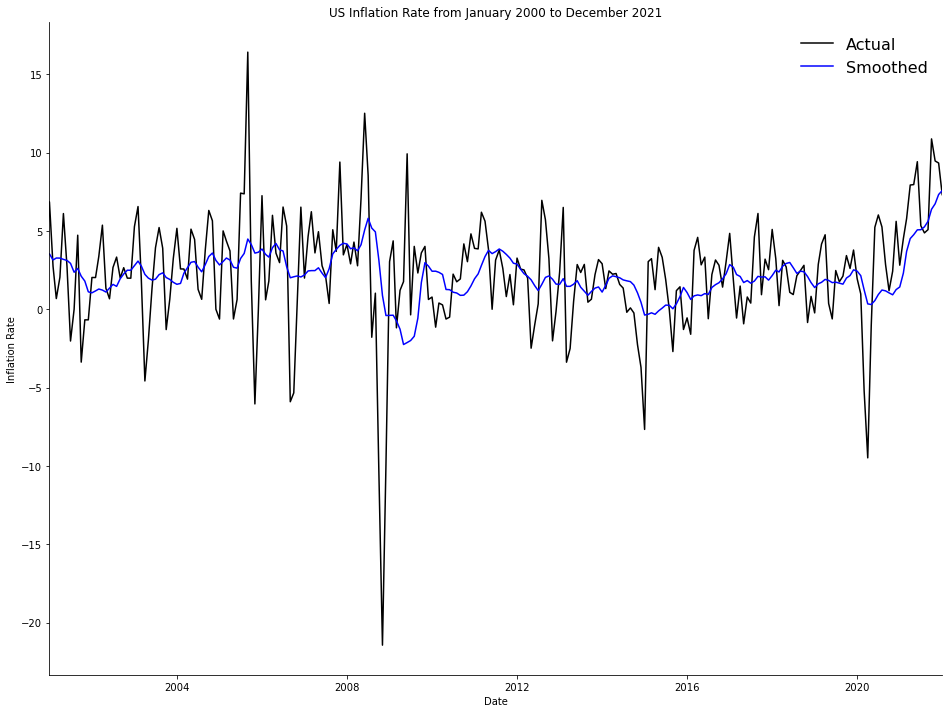

In [102]:
#Visualize the smoothed data on top of the original data
fig, ax = plt.subplots(1,1, figsize=(16,12)) 
ax.plot(data.index, data['Actual'],
       color='black', label="Actual")
       

ax.plot(data.index, data['Smoothed'],
       color='blue', label="Smoothed")
       
ax.set_ylabel('Inflation Rate')  
ax.set_xlabel('Date')                 
ax.set_title('US Inflation Rate from January 2000 to December 2021')

#plt.xlim(['2000-12-31', '2021-12-31'])
ax.set_xlim([datetime.date(2000, 12, 31), datetime.date(2021, 12, 31)])

ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False) 

ax.legend(frameon=False, fontsize=16)
            

plt.show()  

I will now repeat these steps using the exponential smoothing algorithm (without trend) instead of
the unweighted moving average

In [103]:
#https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html

In [104]:
#Fit and forecast using the smoothing algorithm
fit1 = SimpleExpSmoothing(y, initialization_method="heuristic").fit(
    smoothing_level=0.10, optimized=False)
fcast1 = fit1.forecast(3).rename(r"$\alpha=0.1$")

C:\Users\Brayden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Brayden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


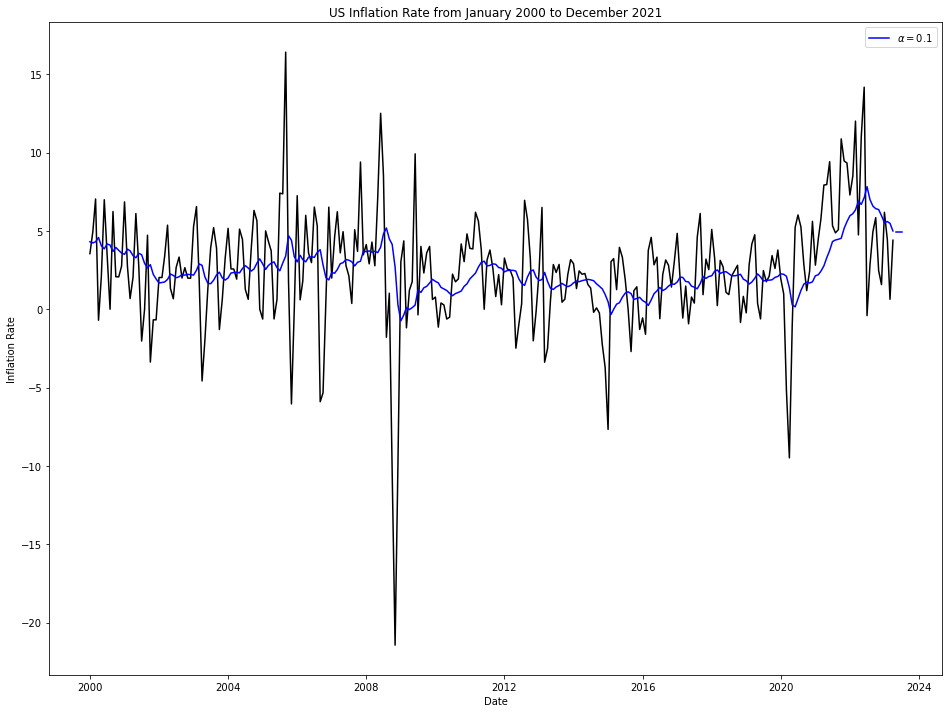

In [105]:
#Visualize the exponential smoothing
plt.figure(figsize=(16, 12))
plt.plot(y, color="black")
plt.plot(fit1.fittedvalues, color="blue")
(line1,) = plt.plot(fcast1, color="blue")

plt.title("US Inflation Rate from January 2000 to December 2021")
plt.xlabel('Date') 
plt.ylabel('Inflation Rate')
plt.legend([line1], [fcast1.name])

C:\Users\Brayden\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Brayden\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


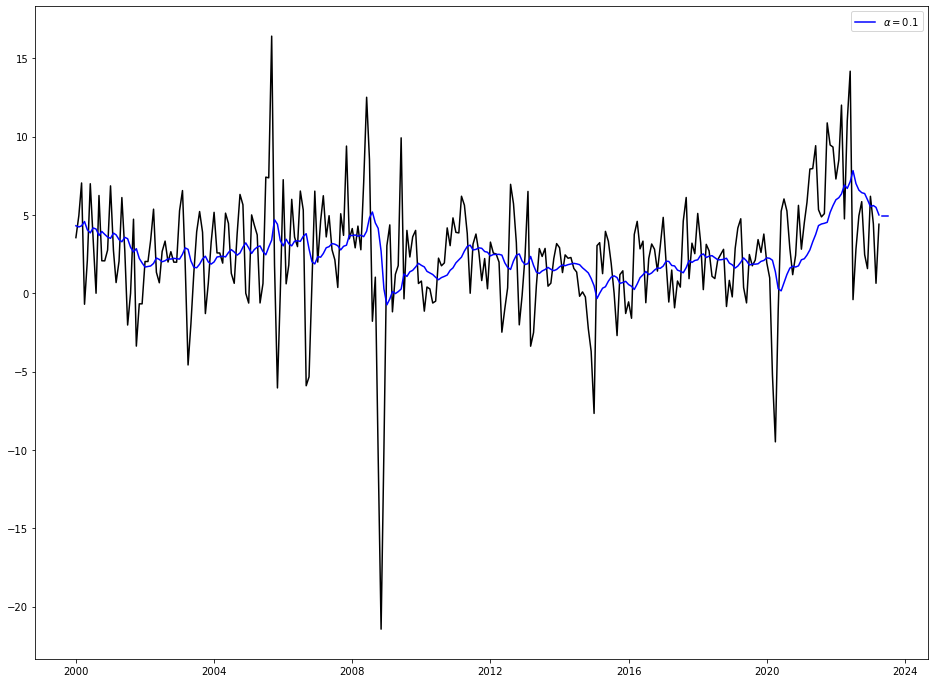

In [106]:
#Forecast and visualize the next 3 values
ins1 = SimpleExpSmoothing(y).fit(smoothing_level=0.1,optimized=False)
ins_cast1 = ins1.forecast(3).rename('alpha=0.1')

plt.figure(figsize=(16, 12))
plt.plot(y, color="black")
plt.plot(fit1.fittedvalues, color="blue")
(line1,) = plt.plot(fcast1, color="blue")

#plt.xlim([datetime.date(2000, 12, 31), datetime.date(2021, 12, 31)])

plt.legend([line1], [fcast1.name])


I will now shift gears to simple linear regression. This is a similar forecasting approach that will allow us to pull predicted future values. I will use the US Real GDP data for this exercise and an attempt to return a 5-year forecast. Because this data is exponential, I will run my analysis on the log of GDP because the simple linear regression is linear.

(b) Compute a point forecast and 95% interval forecast of the log of GDP for each quarter
over the period 2020:I to 2026:IV. Plot and report these forecasts along with actual
GDP in a time series graph.

(c) In a separate table, report the point forecasts from your model for real GDP (not in log
form) for each quarter of the year 2026.

(d) Starting the sample in 1950 is reasonable based on the notion that more information is
better than less information. However, trends can change. Repeat the above two steps
for the estimation period 2000:I to 2019:IV.

In [107]:
start = datetime.datetime(1950, 1, 1)
end = datetime.datetime(2020, 1, 1)

In [108]:
gdp = web.DataReader(['GDPC1'],'fred',start, end)
gdp.index.names = ['Date']
gdp.rename(columns={'GDPC1': 'GDP'}, inplace=True)

In [109]:
#Natural log of GDP
gdp['lnGDP']=np.log(gdp['GDP'])

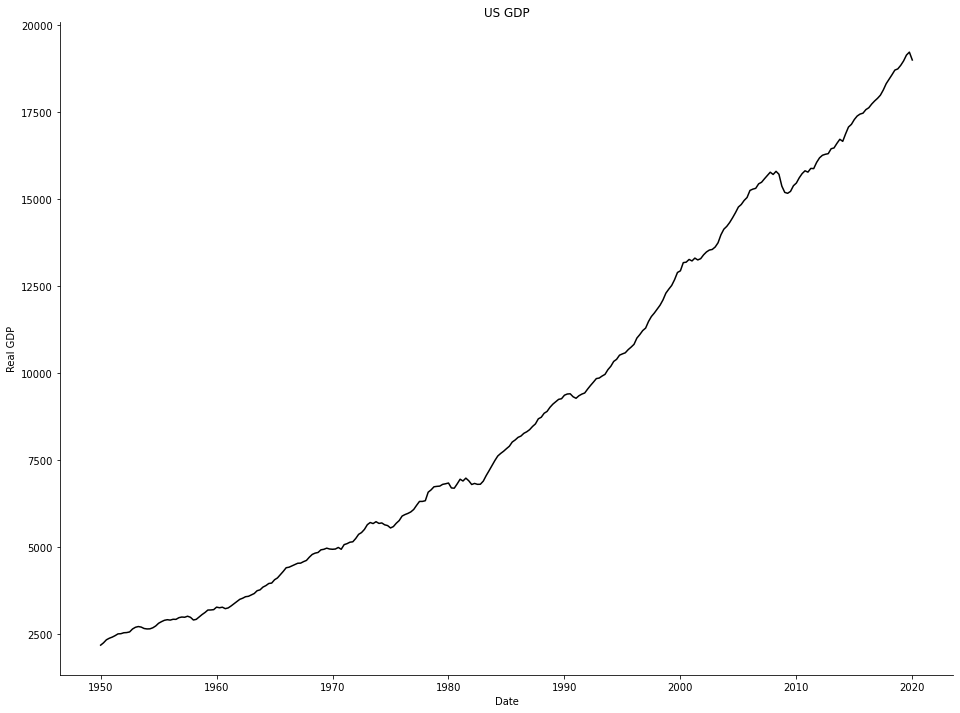

In [110]:
#Visualize initial dataset
fig, ax = plt.subplots(1,1, figsize=(16,12)) 

ax.plot(gdp.index, gdp['GDP'],
       color='black')

ax.set_ylabel('Real GDP')  
ax.set_xlabel('Date')                 
ax.set_title('US GDP')


ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False) 

#ax.legend(frameon=False,loc='upper left',fontsize=16)


plt.show() 

In [111]:
#Create 'days from start' column
gdp['days_from_start'] = (gdp.index - gdp.index[0]).days
gdp

,GDP,lnGDP,days_from_start
Date,,,
1950-01-01,2186.365,7.689996,0
1950-04-01,2253.045,7.720038,90
1950-07-01,2340.112,7.757954,181
1950-10-01,2384.920,7.776921,273
1951-01-01,2417.311,7.790411,365
...,...,...,...
2019-01-01,18835.411,9.843494,25202
2019-04-01,18962.175,9.850201,25292
2019-07-01,19130.932,9.859062,25383


In [112]:
#Create date column
gdp['DATE']=gdp.index
gdp

,GDP,lnGDP,days_from_start,DATE
Date,,,,
1950-01-01,2186.365,7.689996,0,1950-01-01
1950-04-01,2253.045,7.720038,90,1950-04-01
1950-07-01,2340.112,7.757954,181,1950-07-01
1950-10-01,2384.920,7.776921,273,1950-10-01
1951-01-01,2417.311,7.790411,365,1951-01-01
...,...,...,...,...
2019-01-01,18835.411,9.843494,25202,2019-01-01
2019-04-01,18962.175,9.850201,25292,2019-04-01
2019-07-01,19130.932,9.859062,25383,2019-07-01


In [113]:
#Create quarter column
gdp['quarter'] = pd.DatetimeIndex(gdp['DATE']).quarter
gdp

,GDP,lnGDP,days_from_start,DATE,quarter
Date,,,,,
1950-01-01,2186.365,7.689996,0,1950-01-01,1
1950-04-01,2253.045,7.720038,90,1950-04-01,2
1950-07-01,2340.112,7.757954,181,1950-07-01,3
1950-10-01,2384.920,7.776921,273,1950-10-01,4
1951-01-01,2417.311,7.790411,365,1951-01-01,1
...,...,...,...,...,...
2019-01-01,18835.411,9.843494,25202,2019-01-01,1
2019-04-01,18962.175,9.850201,25292,2019-04-01,2
2019-07-01,19130.932,9.859062,25383,2019-07-01,3


In [114]:
#Number the quarters within the dataset
gdp['QUARTER']= list(range(1,282))
gdp

,GDP,lnGDP,days_from_start,DATE,quarter,QUARTER
Date,,,,,,
1950-01-01,2186.365,7.689996,0,1950-01-01,1,1
1950-04-01,2253.045,7.720038,90,1950-04-01,2,2
1950-07-01,2340.112,7.757954,181,1950-07-01,3,3
1950-10-01,2384.920,7.776921,273,1950-10-01,4,4
1951-01-01,2417.311,7.790411,365,1951-01-01,1,5
...,...,...,...,...,...,...
2019-01-01,18835.411,9.843494,25202,2019-01-01,1,277
2019-04-01,18962.175,9.850201,25292,2019-04-01,2,278
2019-07-01,19130.932,9.859062,25383,2019-07-01,3,279


                            OLS Regression Results                            
Dep. Variable:                  lnGDP   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 2.646e+04
Date:                Thu, 18 May 2023   Prob (F-statistic):          1.79e-278
Time:                        16:28:52   Log-Likelihood:                 372.28
No. Observations:                 281   AIC:                            -740.6
Df Residuals:                     279   BIC:                            -733.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8343      0.008   1014.447      0.0

C:\Users\Brayden\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


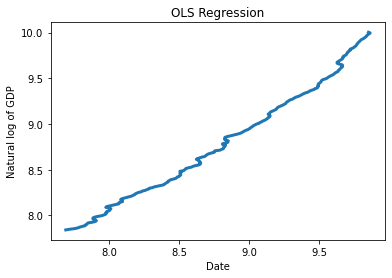

In [115]:
#Utilize statsmodels to fit linear model
X = sm.add_constant(gdp['QUARTER'])
model = sm.OLS(gdp['lnGDP'],X)
results = model.fit()
#plt.scatter(gdp['lnGDP'],gdp['QUARTER'],alpha=0.3)
y_predict = results.params[0] + results.params[1]*gdp['QUARTER']
plt.plot(gdp['lnGDP'],y_predict, linewidth=3)
plt.xlabel('Date')
plt.ylabel('Natural log of GDP')
plt.title('OLS Regression')
print(results.summary())

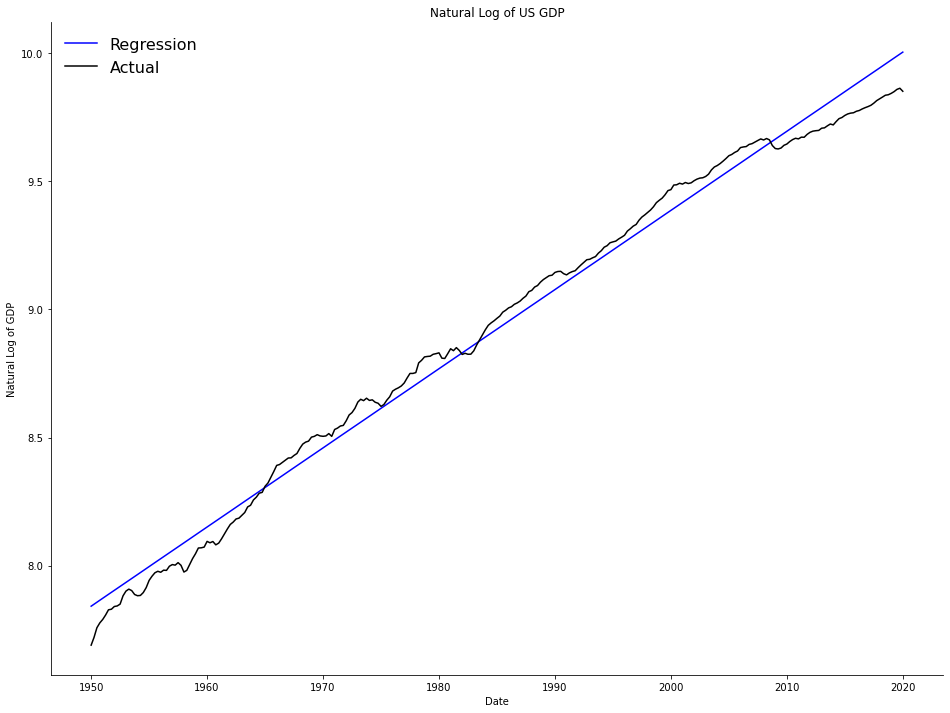

In [116]:
#Visualize linear regression on top of GDP data
fig, ax = plt.subplots(1,1, figsize=(16,12)) 
ax.plot(y_predict.index, y_predict.values,
       color='blue', label = 'Regression',
       linestyle='-')

ax.plot(gdp.index, gdp['lnGDP'],
       color='black', label= 'Actual',
       linestyle='-')

ax.set_ylabel('Natural Log of GDP')  
ax.set_xlabel('Date')                 
ax.set_title('Natural Log of US GDP')


ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False) 

ax.legend(frameon=False,loc='upper left',fontsize=16)

#ax.annotate('Dataset was downloaded from HELIX Hellenic Data Service',
#            xy = (1.0, -0.1),
#            xycoords='axes fraction',
#            ha='right',
#            va="center",
#            fontsize=10)


plt.show()  

In [117]:
#Create list for future quarters to enable prediction
future_list=list(range(282,310))

In [118]:
con = [1 for i in range(28)]

In [119]:
pdf=pd.DataFrame(future_list, con)

In [120]:
future_qdates= pd.date_range('2020-01-02', periods=28, freq="Q")
future_qdates

DatetimeIndex(['2020-03-31', '2020-06-30', '2020-09-30', '2020-12-31',
               '2021-03-31', '2021-06-30', '2021-09-30', '2021-12-31',
               '2022-03-31', '2022-06-30', '2022-09-30', '2022-12-31',
               '2023-03-31', '2023-06-30', '2023-09-30', '2023-12-31',
               '2024-03-31', '2024-06-30', '2024-09-30', '2024-12-31',
               '2025-03-31', '2025-06-30', '2025-09-30', '2025-12-31',
               '2026-03-31', '2026-06-30', '2026-09-30', '2026-12-31'],
              dtype='datetime64[ns]', freq='Q-DEC')

In [121]:
pdf['Dates']=future_qdates
pdf.set_index(pdf['Dates'], inplace=True)

In [122]:
pdf.drop(['Dates'], axis=1, inplace=True)

In [123]:
pdf['QUARTERS']=future_list

In [124]:
pdf['QUARTER']= list(range(282,310))

In [125]:
pdf.iloc[0]

0           282
QUARTERS    282
QUARTER     282
Name: 2020-03-31 00:00:00, dtype: int64

In [126]:
#Utilize sm linear regression coefficient and constant to fit future values
pdf['prediction']= (pdf['QUARTERS']*0.0077)+7.8344

In [127]:
#Find 95% confident lower bound
pdf['low_bound']=pdf['prediction']-(1.96*(.0080475))

In [128]:
#Find 95% confident upper bound
pdf['upper_bound']=pdf['prediction']+(1.96*(.0080475))

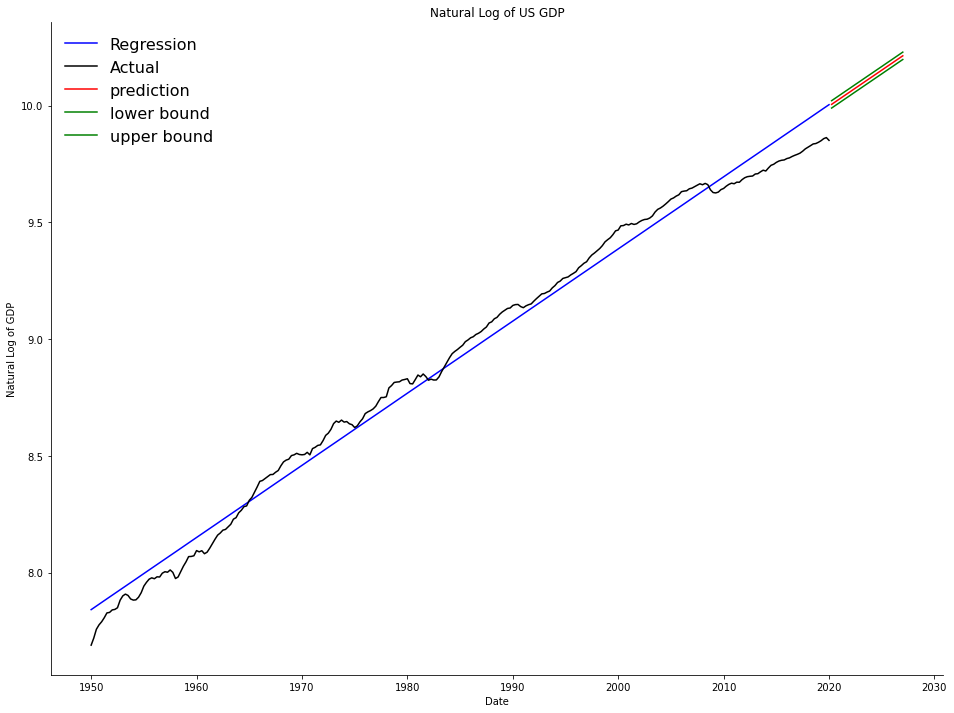

In [129]:
#Plot final prediction on log GDP
fig, ax = plt.subplots(1,1, figsize=(16,12)) 

ax.plot(y_predict.index, y_predict.values,
       color='blue', label = 'Regression',
       linestyle='-')

ax.plot(gdp.index, gdp['lnGDP'],
       color='black', label= 'Actual',
       linestyle='-')

ax.plot(pdf.index, pdf['prediction'],
       color='red', label = 'prediction')

ax.plot(pdf.index, pdf['low_bound'],
       color='green', label = 'lower bound')
        
ax.plot(pdf.index, pdf['upper_bound'],
       color='green', label = 'upper bound')

ax.set_ylabel('Natural Log of GDP')  
ax.set_xlabel('Date')                 
ax.set_title('Natural Log of US GDP')


ax.spines['right'].set_visible(False) 
ax.spines['top'].set_visible(False) 

ax.legend(frameon=False,loc='upper left',fontsize=16)


plt.show()  

In [130]:
#Convert back to real GDP
pdf['realGDP']=np.exp(pdf['prediction'])
pdf

,0,QUARTERS,QUARTER,prediction,low_bound,upper_bound,realGDP
Dates,,,,,,,
2020-03-31,282,282,282,10.0058,9.990027,10.021573,22154.590499
2020-06-30,283,283,283,10.0135,9.997727,10.029273,22325.839308
2020-09-30,284,284,284,10.0212,10.005427,10.036973,22498.411822
2020-12-31,285,285,285,10.0289,10.013127,10.044673,22672.318273
2021-03-31,286,286,286,10.0366,10.020827,10.052373,22847.568973
2021-06-30,287,287,287,10.0443,10.028527,10.060073,23024.174312
2021-09-30,288,288,288,10.0520,10.036227,10.067773,23202.144762
2021-12-31,289,289,289,10.0597,10.043927,10.075473,23381.490873
2022-03-31,290,290,290,10.0674,10.051627,10.083173,23562.223279
